This script follows general pipeline of [the standard CIFAR10 Pytorch example](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html). It extracts grey scale images from the dataset.

The steps are:

1. Load and normalizing the FRDEEPv 2.0 training and test datasets using torchvision
2. Define a Convolutional Neural Network
3. Define a loss function (we use AdaGrad here)
4. Train the network on the training data (we train on FIRST images here)
5. Test the network on the test data

First import some standard python libraries for plotting stuff and handling arrays:

In [1]:
import matplotlib.pyplot as plt
import numpy as np

Then import the pytorch, torchvision and torchsummary libraries:

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary

Then import the pytorch neural network stuff:

In [3]:
import torch.nn as nn
import torch.nn.functional as F

Then import the oprimization library from pytorch:

In [4]:
import torch.optim as optim

Finally import the FRDEEP v2.0 pytorch dataset class. This is not provided with pytorch, you need to [grab it from the FRDEEPv2.0 github](
[waiting for uploading]).

In [5]:
from FRDEEPv2_foundation import FRDEEPv2

The output of torchvision datasets are PILImage images of range [0, 1]. We transform them to Tensors of normalized range [-1, 1]. We here also randomly rotate image from -45 to 45 deg (in step of 1 deg) before every epoch of training

In [6]:
transform = transforms.Compose(
    [transforms.RandomRotation([-45,45]),
     transforms.ToTensor(),
     transforms.Normalize([0.5],[0.5])])

Load in the training and test datasets. The first time you do this it will download the data to your working directory, but once the data is there it will just use it without repeating the download.

In [7]:
trainset = FRDEEPv2(root1='./4_DataPickle_Generation/',root2='./4_DataPickle_Generation/',root3='./4_DataPickle_Generation/', train=True, download=False, transform=transform)
batch_size_train = 2
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size_train, shuffle=True, num_workers=2)

(460, 150, 150, 1)
(460, 150, 150, 1)


In [8]:
testset = FRDEEPv2(root1='./4_DataPickle_Generation/',root2='./4_DataPickle_Generation/',root3='./4_DataPickle_Generation/', train=False, download=False, transform=transform)
batch_size_test = 2
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size_test, shuffle=True, num_workers=2)

(198, 150, 150, 1)
(198, 150, 150, 1)


There are two classes in this dataset: FRI and FRII:

In [9]:
classes = ('FRI', 'FRII')

A little function to display images nicely:

In [10]:
def imshow(img):
    # unnormalize
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

Take a look at some randomly selected samples to see how they appear:

In [11]:
# get some random training images
dataiter = iter(trainloader)
images1_tr,images2_tr,object_id_tr,labels_tr = dataiter.next() # images1:NVSS, images2:FIRST

## Note: images1, images2 -> NVSS image, FIRST image of the same object. For visualizing/training/testing on NVSS image inputs, simply replace images2 with images1.

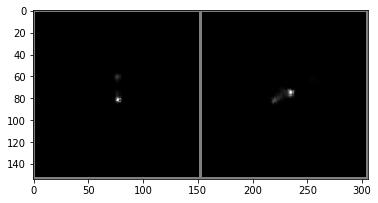

Object ID:  TXS 1455+253 TXS 1421+006
GroundTruth:   FRII  FRII


In [12]:
# print images
imshow(torchvision.utils.make_grid(images2_tr))
print('Object ID: ', ' '.join('%5s' % object_id_tr[j] for j in range(batch_size_train)))
print('GroundTruth: ', ' '.join('%5s' % classes[labels_tr[j]] for j in range(batch_size_train)))

Define a neural network that takes greyscale images as input:

In [13]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 34 * 34, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # conv1 output width: input_width - (kernel_size - 1) => 150 - (5-1) = 146
        # pool 1 output width: int(input_width/2) => 73
        x = self.pool(F.relu(self.conv1(x)))
        # conv2 output width: input_width - (kernel_size - 1) => 73 - (5-1) = 69
        # pool 2 output width: int(input_width/2) => 34
        x = self.pool(F.relu(self.conv2(x)))  
        x = x.view(-1, 16 * 34 * 34)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [14]:
net = Net()
summary(net,(1,150,150))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 6, 146, 146]             156
         MaxPool2d-2            [-1, 6, 73, 73]               0
            Conv2d-3           [-1, 16, 69, 69]           2,416
         MaxPool2d-4           [-1, 16, 34, 34]               0
            Linear-5                  [-1, 120]       2,219,640
            Linear-6                   [-1, 84]          10,164
            Linear-7                   [-1, 10]             850
Total params: 2,233,226
Trainable params: 2,233,226
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.09
Forward/backward pass size (MB): 1.94
Params size (MB): 8.52
Estimated Total Size (MB): 10.55
----------------------------------------------------------------


We'll use Classification Cross-Entropy loss and Adagrad with momentum for optimization:

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adagrad(net.parameters(), lr=0.01)

Run 10 epochs of training:

In [16]:
nepoch = 10  # number of epochs
print_num = 50
for epoch in range(nepoch):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        
        images1,images2,object_id,labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(images2) # train with FIRST images
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % print_num == (print_num-1):    # print every 50 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / print_num))
            running_loss = 0.0

print('Finished Training')

[1,    50] loss: 0.964
[1,   100] loss: 0.697
[1,   150] loss: 0.710
[1,   200] loss: 0.687
[2,    50] loss: 0.681
[2,   100] loss: 0.612
[2,   150] loss: 0.651
[2,   200] loss: 0.568
[3,    50] loss: 0.577
[3,   100] loss: 0.586
[3,   150] loss: 0.538
[3,   200] loss: 0.574
[4,    50] loss: 0.547
[4,   100] loss: 0.514
[4,   150] loss: 0.514
[4,   200] loss: 0.548
[5,    50] loss: 0.428
[5,   100] loss: 0.533
[5,   150] loss: 0.473
[5,   200] loss: 0.568
[6,    50] loss: 0.522
[6,   100] loss: 0.518
[6,   150] loss: 0.514
[6,   200] loss: 0.392
[7,    50] loss: 0.439
[7,   100] loss: 0.430
[7,   150] loss: 0.491
[7,   200] loss: 0.440
[8,    50] loss: 0.412
[8,   100] loss: 0.461
[8,   150] loss: 0.494
[8,   200] loss: 0.322
[9,    50] loss: 0.405
[9,   100] loss: 0.497
[9,   150] loss: 0.400
[9,   200] loss: 0.434
[10,    50] loss: 0.383
[10,   100] loss: 0.421
[10,   150] loss: 0.346
[10,   200] loss: 0.385
Finished Training


Now we'll try out a couple of test samples just for visual kicks. First load them up and take a look at the true labels:

In [17]:
dataiter = iter(testloader)
images1_te,images2_te,object_id_te,labels_te = dataiter.next()

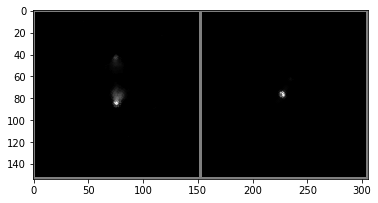

Object ID:  TXS 1529+110 TXS 1459+133
GroundTruth:   FRII  FRII


In [18]:
# print images
imshow(torchvision.utils.make_grid(images2_te))
print('Object ID: ', ' '.join('%5s' % object_id_te[j] for j in range(batch_size_test)))
print('GroundTruth: ', ' '.join('%5s' % classes[labels_te[j]] for j in range(batch_size_test)))

Then see what the network predicts that they are:

In [19]:
outputs = net(images2_te)

In [20]:
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(batch_size_test)))

Predicted:   FRII   FRI


Now calculate the overall accuracy of the network on **all** the test images:

In [21]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images1,images2,object_id,labels = data
        outputs = net(images2)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 198 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 198 test images: 84 %


This is a imbalanced dataset, so let's take a look at the accuracy for individual classes (class recall):

In [22]:
class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))

with torch.no_grad():
    for data in testloader:
        images1,images2,object_id,labels = data
        outputs = net(images2)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(batch_size_test):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

In [23]:
for i in range(len(classes)):
    print('Class recall of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

Class recall of   FRI : 82 %
Class recall of  FRII : 82 %
